In [1]:
import gym
import numpy as np
import random
import torch
from itertools import count


In [2]:
env = gym.make('MountainCarContinuous-v0')

In [3]:
env.action_space

Box(1,)

In [4]:
env.observation_space

Box(2,)

In [5]:
env.reset()
for i in range(500):
    env.render()
    env.step(env.action_space.sample())
env.close()

KeyboardInterrupt: 

In [5]:
env.close()
env.reset()

array([-0.52775357,  0.        ])

In [5]:
from time import sleep

for i in range(50):
    env.step(env.action_space.sample())
    env.render()
    sleep(0.01)
env.close()

AssertionError: Cannot call env.step() before calling reset()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [8]:
class Memory():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.short_memory = []
        
    def push(self, old_state, action, reward, new_state, final):
        self.short_memory.append([old_state, action, reward, new_state, final])
        
    def commit(self, final=True): 
        
#         R = self.short_memory[-1][2]
#         for i in range(len(self.short_memory) - 1):
#             R = self.short_memory[-2 -i][2] + R*0.99
#             self.short_memory[-2 -i][2] = R
        
        if len(self.memory) + len(self.short_memory) < self.capacity:
            self.memory.extend(self.short_memory)
        else:
            for memo in self.short_memory:
                self.memory.insert(random.randint(0, len(self.memory) - 1), memo)
                
        self.memory = self.memory[:self.capacity]
        self.short_memory = []

In [32]:
class Actor_net(torch.nn.Module):
    def __init__(self):
        super(Actor_net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )
    
    def forward(self, x):
        return self.model(x)
    
class Qritic_net(torch.nn.Module):
    def __init__(self):
        super(Qritic_net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
#             torch.nn.LeakyReLU(inplace=True),
#             torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.LeakyReLU(),
        )
        
        self.head = torch.nn.Sequential(
            torch.nn.Linear(64 + 1, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 1),
        )
    
    def forward(self, state, actions):
        out = self.model(state)
        out = torch.cat((out, actions), dim=1)
        out = self.head(out)
        return out

policy_actor, policy_critic = Actor_net().to(device), Qritic_net().to(device)
target_actor, target_critic = Actor_net().to(device), Qritic_net().to(device)

target_actor.load_state_dict(policy_actor.state_dict())
target_critic.load_state_dict(policy_critic.state_dict())

critic_optim = torch.optim.Adam(policy_critic.parameters(), lr=0.001)
actor_optim = torch.optim.Adam(policy_actor.parameters(), lr=0.001)
# optim = torch.optim.SGD(policy_net.parameters(), lr=0.001)

# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optim, step_size=100, gamma=0.84)    

In [34]:
# env = gym.make('CartPole-v0')
# env._max_episode_steps = 500

EPS = 0.999
EPS_MIN = 0.0001
GAMMA = 0.999999
c = 0


def get_model_action(model, state, device, train=True):
    global EPS, EPS_MIN, GAMMA
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
    with torch.no_grad():
        model_output = model(torch.FloatTensor(state).to(device).unsqueeze(0)).cpu().detach().numpy()
        action = model_output[0]
#             print(state, model_output, action)
            
    if train:
        
        action = np.clip(action, -1, 1)
        noise = (random.random() * 2) -1
        noise = noise * EPS  * 5
        action = action + noise
        action = np.clip(action, -1, 1)
    
    global c
    c += 1
    if c <= 30:
        print(action)
    
    return action

def train(memory, device):
    memory = memory.memory
    try:
        memory = random.sample(memory, 128)
    except ValueError:
        return

    s0 = [x[0] for x in memory]
    a = [x[1] for x in memory]
    r = [[x[2]] for x in memory]
    s1 = [x[3] for x in memory]
    done = [1. if x[4] else 0. for x in memory]


    s0 = torch.FloatTensor(s0).to(device)
    s1 = torch.FloatTensor(s1).to(device)
    a = torch.FloatTensor(a).to(device)
    r = torch.FloatTensor(r).to(device)
    done = torch.FloatTensor(done).to(device)

    
    y = target_critic(s1, target_actor(s1)).mul(0.999).add(r)
    target = policy_critic(s0, a)
#     loss = (y.detach() - target).view(-1).pow(2).mean()
    loss = torch.nn.functional.smooth_l1_loss(y.detach(), target)
    
#     print('s0', s0)
#     print('a', a)
#     print('r', r)
#     print('s1', s1)
    
#     print('y', y)
#     print('target', target)
#     print('loss', loss.item())
#     assert False
    
    critic_optim.zero_grad()
#     torch.nn.utils.clip_grad_norm_(policy_critic.parameters(), 1)
    loss.backward()
    critic_optim.step()
    
    policy_actions = policy_actor(s0)
    q_values = policy_critic(s0, policy_actions)
    
    loss = q_values.mean().mul(-1)
    actor_optim.zero_grad()
    loss.backward()
    actor_optim.step()
    
#     print('policy_actions', policy_actions)
#     print('q_values', q_values)
#     print('loss', loss.item())
#     assert False
    
    def soft_update(target_model, local_model, tau=0.01):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
                
    soft_update(target_actor, policy_actor)
    soft_update(target_critic, policy_critic)
        
#     scheduler.step()

memory = Memory(capacity=100000)  
len_mem = []
cum_reward_mem = []

try:
    for episode in range(10000):
        state = env.reset()

        cum_reward = []
        for i in count():
#             env.render()

            action = get_model_action(policy_actor, state, device)
            old_state = state
            state, reward, done, info = env.step(action)
            
            reward = max(-1, state[1])
            reward *= 10
#             reward /= 10

            cum_reward.append(reward)

            
            if not done:
                memory.push(old_state, action, reward, state, False)
            else:
                env.close()
                len_mem.append(i)
                cum_reward_mem.append(np.sum(cum_reward))

                if state[1] >= 0.59:
                    reward = 100
                    final = True
                else:
                    final = False
                
                memory.push(old_state, action, reward, state, final)
                memory.commit()
                break

        
        if episode % 10 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, np.mean(len_mem[-10:]), EPS))
        
        for _ in range(1):
            train(memory, device)

except KeyboardInterrupt:
    env.close()

[1.]
[0.55808914]
[-1.]
[1.]
[-0.0734058]
[1.]
[-1.]
[-1.]
[-1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[-1.]
[1.]
[1.]
[-0.2208854]
[1.]
[1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[0.5224212]
[-1.]
[1.]
[1.]
[1.]
Episode   0:    499.000 iterations, eps=0.998501
Episode  10:    499.000 iterations, eps=0.993521
Episode  20:    495.600 iterations, eps=0.988599
Episode  30:    497.600 iterations, eps=0.983682
Episode  40:    499.000 iterations, eps=0.978776
Episode  50:    486.500 iterations, eps=0.974016
Episode  60:    499.000 iterations, eps=0.969158
Episode  70:    493.400 iterations, eps=0.964378
Episode  80:    483.900 iterations, eps=0.959713
Episode  90:    470.700 iterations, eps=0.955197
Episode 100:    499.000 iterations, eps=0.950433
Episode 110:    499.000 iterations, eps=0.945693
Episode 120:    499.000 iterations, eps=0.940976
Episode 130:    499.000 iterations, eps=0.936283
Episode 140:    485.200 iterations, eps=0.931742
Episode 150:    499.000 iterations, eps=0.927095
Episode 160:    493.200 i

Episode 1630:    499.000 iterations, eps=0.444564
Episode 1640:    499.000 iterations, eps=0.442346
Episode 1650:    499.000 iterations, eps=0.440140
Episode 1660:    499.000 iterations, eps=0.437945
Episode 1670:    499.000 iterations, eps=0.435761
Episode 1680:    499.000 iterations, eps=0.433587
Episode 1690:    473.000 iterations, eps=0.431537
Episode 1700:    499.000 iterations, eps=0.429385
Episode 1710:    496.100 iterations, eps=0.427256
Episode 1720:    499.000 iterations, eps=0.425125
Episode 1730:    499.000 iterations, eps=0.423004
Episode 1740:    499.000 iterations, eps=0.420895
Episode 1750:    499.000 iterations, eps=0.418795
Episode 1760:    493.300 iterations, eps=0.416730
Episode 1770:    499.000 iterations, eps=0.414652
Episode 1780:    499.000 iterations, eps=0.412584
Episode 1790:    499.000 iterations, eps=0.410526
Episode 1800:    499.000 iterations, eps=0.408479
Episode 1810:    499.000 iterations, eps=0.406441
Episode 1820:    499.000 iterations, eps=0.404414


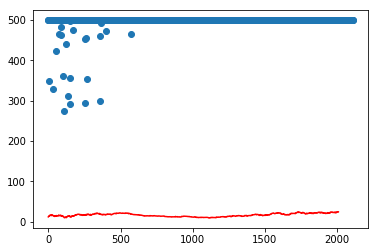

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


plt.figure()
plt.plot(len_mem, 'o')
plt.plot(pd.Series(cum_reward_mem).rolling(100).mean().dropna().values, color='red')

In [29]:
try:
#     env.seed = random.randint(0, 100000)
    obs = env.reset()
    env._max_episode_steps = 500
    for t in count():
        
        if t % 500 == 0:
            print(t)
        
        env.render()
        global EPS
        EPS = 0.95
        action = get_model_action(policy_actor, obs, device, train=False)
        state, reward, done, info = env.step(action)
        reward = max(-0.1, state[0])
#             reward *= 100
        reward /= 10
        print(action, reward, state)
        if done:
            env.close()
            break

    print(t)
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print(t)

0
[1.] -0.01 [-0.42488497  0.00077599]
[1.] -0.01 [-0.42333856  0.00154641]
[1.] -0.01 [-0.42103281  0.00230574]
[1.] -0.01 [-0.41798423  0.00304858]
[1.] -0.01 [-0.41421457  0.00376966]
[1.] -0.01 [-0.40975065  0.00446392]
[1.] -0.01 [-0.40462409  0.00512657]
[1.] -0.01 [-0.398871    0.00575308]
[1.] -0.01 [-0.3925317  0.0063393]
[1.] -0.01 [-0.38565027  0.00688143]
[1.] -0.01 [-0.37827417  0.0073761 ]
[1.] -0.01 [-0.37045381  0.00782037]
[1.] -0.01 [-0.36224205  0.00821176]
[1.] -0.01 [-0.35369375  0.0085483 ]
[1.] -0.01 [-0.34486527  0.00882848]
[1.] -0.01 [-0.33581398  0.00905129]
[1.] -0.01 [-0.32659775  0.00921623]
[1.] -0.01 [-0.31727451  0.00932324]
[1.] -0.01 [-0.30790176  0.00937275]
[1.] -0.01 [-0.29853619  0.00936558]
[1.] -0.01 [-0.28923322  0.00930297]
[1.] -0.01 [-0.28004671  0.00918651]
[1.] -0.01 [-0.2710286   0.00901811]
[1.] -0.01 [-0.26222864  0.00879996]
[1.] -0.01 [-0.25369416  0.00853447]
[1.] -0.01 [-0.24546991  0.00822425]
[1.] -0.01 [-0.23759788  0.00787204]
[

[1.] -0.01 [-0.34125307 -0.00912451]
[1.] -0.01 [-0.35017798 -0.00892491]
[1.] -0.01 [-0.35884566 -0.00866768]
[1.] -0.01 [-0.36719929 -0.00835363]
[1.] -0.01 [-0.37518335 -0.00798406]
[1.] -0.01 [-0.3827441  -0.00756076]
[1.] -0.01 [-0.38983011 -0.00708601]
[1.] -0.01 [-0.39639267 -0.00656256]
[1.] -0.01 [-0.40238629 -0.00599362]
[1.] -0.01 [-0.4077691  -0.00538281]
[1.] -0.01 [-0.41250326 -0.00473415]
[1.] -0.01 [-0.41655528 -0.00405203]
[1.] -0.01 [-0.41989641 -0.00334113]
[1.] -0.01 [-0.42250282 -0.00260641]
[1.] -0.01 [-0.42435588 -0.00185306]
[1.] -0.01 [-0.42544232 -0.00108643]
[1.] -0.01 [-4.25754330e-01 -3.12013632e-04]
[1.] -0.01 [-0.42528968  0.00046465]
[1.] -0.01 [-0.42405171  0.00123797]
[1.] -0.01 [-0.4220493   0.00200242]
[1.] -0.01 [-0.41929678  0.00275252]
[1.] -0.01 [-0.41581382  0.00348296]
[1.] -0.01 [-0.41162523  0.00418859]
[1.] -0.01 [-0.40676074  0.00486449]
[1.] -0.01 [-0.40125471  0.00550604]
[1.] -0.01 [-0.39514579  0.00610892]
[1.] -0.01 [-0.38847659  0.006

[1.] -0.01 [-0.20584332 -0.00514849]
[1.] -0.01 [-0.21153008 -0.00568677]
[1.] -0.01 [-0.21773014 -0.00620005]
[1.] -0.01 [-0.22441556 -0.00668543]
[1.] -0.01 [-0.23155549 -0.00713993]
[1.] -0.01 [-0.23911609 -0.0075606 ]
[1.] -0.01 [-0.24706057 -0.00794448]
[1.] -0.01 [-0.25534922 -0.00828866]
[1.] -0.01 [-0.26393952 -0.0085903 ]
[1.] -0.01 [-0.2727862  -0.00884668]
[1.] -0.01 [-0.28184143 -0.00905523]
[1.] -0.01 [-0.291055   -0.00921358]
[1.] -0.01 [-0.30037459 -0.00931959]
[1.] -0.01 [-0.309746   -0.00937141]
[1.] -0.01 [-0.31911352 -0.00936752]
[1.] -0.01 [-0.32842028 -0.00930676]
[1.] -0.01 [-0.33760866 -0.00918838]
[1.] -0.01 [-0.3466207  -0.00901204]
[1.] -0.01 [-0.35539859 -0.00877789]
[1.] -0.01 [-0.36388512 -0.00848653]
[1.] -0.01 [-0.37202419 -0.00813908]
[1.] -0.01 [-0.37976131 -0.00773711]
[1.] -0.01 [-0.38704403 -0.00728272]
[1.] -0.01 [-0.39382251 -0.00677848]
[1.] -0.01 [-0.4000499 -0.0062274]
[1.] -0.01 [-0.40568284 -0.00563294]
[1.] -0.01 [-0.41068182 -0.00499898]
[1.

In [20]:
model = policy_net

In [21]:
model.to('cpu')

Qnet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [22]:
torch.save(model, 'cart.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
model = torch.load('cart.torch')

In [24]:
model.to(device)

Qnet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [25]:
policy_net = model